In [1]:
!nvidia-smi

Tue Jul 23 20:47:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   33C    P8               6W / 185W |    194MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
"""
Implementation of a Resnet-18 model for classification of rooftop materials 
Washington, D.C. from PlanetScope Imagery
"""

import os, time, glob, gc
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torchsat.models.classification import resnet18, resnet50
from torch.utils.data.dataloader import default_collate

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from shapely.geometry import box
from fiona.crs import from_epsg

import warnings
warnings.filterwarnings("ignore")

plt.ion() # interactive

# Projection information
wgs = from_epsg(4326)
proj = from_epsg(32618)
print(f'Projected CRS: {proj}')

print("Successfully imported all packages!")

Projected CRS: EPSG:32618
Successfully imported all packages!


In [2]:
class RoofImageDataset_Planet(Dataset):
    """Class to handle PlanetScope SuperDove imagery for Resnet-18"""

    def __init__(self, gdf, img_path, n_bands=8, imgdim=64, transform=None):
        """
        Args:
            gdf: Geodataframe containing 'geometry' column and 'class_code' column
            img_path: the path to the PlanetScope SuperDove composite image (single mosaic file)
                - see 'psscene-prep.py' for spectral indices calculation
            imgdim (int): Image dimension for CNN implementation
            transform (callable, optional): Optional transform to be applied on a sample

        Returns image chunks with class labels
        """

        if not os.path.exists(img_path):
            raise ValueError(f'Image does not exists: {img_path}')

        self.geometries = [p.centroid for p in gdf.geometry.values]
        self.img = img_path
        self.image_dim = imgdim # resnet window dimension, defaults to 64
        self.n_bands = n_bands
        self.Y = gdf.code.values
        self.transform = transform
        
    
    def __len__(self):
        return len(self.geometries)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Sample the PlanetScope image
        left, bottom, right, top = self.geometries[idx].bounds
        geom = self.geometries[idx]

        try:
            sample = self.sample_image(geom)  # run the sampling function

            cc = self.Y[idx]  # get the class codes
            
            # Ensure the sample has the correct dimensions
            if sample.shape[1:] != (self.image_dim, self.image_dim):
                raise ValueError(f'Invalid sample shape: {sample.shape}')

            if self.transform:
                sample = self.transform(sample)  # torchvision transform
        
        except Exception as e:
            print(f"Skipping invalid sample at index {idx}: {e}")
            return None  # Return None for invalid samples
        
        # Convert the sample array to a Torch object
        sample = torch.from_numpy(sample)

        return {'image': sample.type(torch.FloatTensor),
                'code': torch.tensor(cc).type(torch.LongTensor)}
        
        
    def sample_image(self, geom):
        # Sample the image at each geometry
        samples = [] # store the samples in a list

        N = self.image_dim
        half_N = self.image_dim / 2
            
        # Use the windows.from_bounds() method to return the window
        # Returns image chunks from training data locations
        with rio.open(self.img) as src:
            py, px = src.index(geom.x, geom.y)
            window = rio.windows.Window(px - N // 2, py - N // 2, N, N)
            
            # Read the data in the window
            # clip is a nbands * N * N numpy array
            clip = src.read(window=window)

            # Handle the case where the sample is smaller than the expected size
            if clip.shape[1:] != (N, N):
                padding = [(0, 0), (0, max(0, N - clip.shape[1])), (0, max(0, N - clip.shape[2]))]
                clip = np.pad(clip, padding, mode='constant', constant_values=0)

            if clip.shape != (8, N, N):
                raise ValueError(f'Invalid sample shape: {clip.shape}')
            else:
                samples.append(clip)

            del clip, py, px, window

        # Convert the image chunk to a numpy array
        samples_arr = np.array(samples)

        del samples # Clear up memory

        # Make sure there is valid data
        if samples_arr.sum() > 0:
            ans = np.ma.masked_equal(samples_arr, 0).mean(axis=0)
        else:
            ans = samples_arr.mean(axis=0)

        del samples_arr

        return ans


def make_good_batch(batch, n_bands=8, img_dim=64):
    """
    Removes bad samples if image dimensions do not match.
    
    batch: list of dictionaries, each containing 'image' tensor and 'code' tensor
    
    returns: list of dictionaries same as input with samples having non-matching image dims removed
    """
    valid_samples = []

    for sample in batch:
        if sample is not None:
            image, code = sample['image'], sample['code']
            if code != 255 and not torch.isnan(code) and not torch.isinf(code):
                if not torch.isnan(image).any() and not torch.isinf(image).any():
                    if image.shape == (n_bands, img_dim, img_dim):  # Ensure dimensions match
                        valid_samples.append(sample)
            del image, code

    if not valid_samples:
        return None

    return default_collate(valid_samples)
    del valid_samples, sample


def print_raster(raster,open_file):
    """
    :param raster: input raster file
    :param open_file: should the file be opened or not
    :return: print statement with raster information
    """
    if open_file is True:
        img = rxr.open_rasterio(raster,masked=True).squeeze()
    else:
        img = raster
    print(
        f"shape: {img.rio.shape}\n"
        f"resolution: {img.rio.resolution()}\n"
        f"bounds: {img.rio.bounds()}\n"
        f"sum: {img.sum().item()}\n"
        f"CRS: {img.rio.crs}\n"
        f"NoData: {img.rio.nodata}"
        f"Array: {img}"
    )
    del img


def balance_sampling(df, ratio=1, strategy='undersample'):
    """
    Generate balanced sample from training data based on the given ratio.
    """
    # Get the class counts
    class_counts = df['class_code'].value_counts()
    min_class_count = class_counts.min()
    
    # Calculate the target count for each class based on the ratio
    target_count = {class_label: min(min_class_count * ratio, len(df[df['class_code'] == class_label]))
                    for class_label in class_counts.index}

    # Create an empty list to store balanced dataframes
    balanced_dfs = []

    for class_label in class_counts.index:
        class_df = df[df['class_code'] == class_label]

        if strategy == 'undersample':
            # Under-sample the majority class
            balanced_class_df = resample(class_df, replace=False, n_samples=target_count[class_label], random_state=42)
        elif strategy == 'oversample':
            # Over-sample the minority class
            balanced_class_df = resample(class_df, replace=True, n_samples=target_count[class_label], random_state=42)

        balanced_dfs.append(balanced_class_df)

    balanced_df = pd.concat(balanced_dfs)
    return balanced_df

    

print("Class and functions ready to use!")

Class and functions ready to use!


In [4]:
# os.chdir('/home/jovyan')
print(os.getcwd())

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/code


In [6]:
maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/'

# Load the training data (footprints)
gdf_path = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
footprints = gpd.read_file(gdf_path)
footprints.head()

,class_code,areaUTMsqft,uid,description,code,geometry
0,CS,357.783709,1CS,Composition Shingle,0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,CS,918.640862,2CS,Composition Shingle,0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,CS,1383.414170,3CS,Composition Shingle,0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,CS,836.410297,4CS,Composition Shingle,0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,CS,330.514264,5CS,Composition Shingle,0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [7]:
# Calculate the 'optimal' window size from the footprint areas
mean_area_sqft = int(footprints.areaUTMsqft.values.mean())
pct90_area_sqft = np.percentile(footprints.areaUTMsqft, 90)
print(f'Mean footprint area (sqm): {mean_area_sqft * 0.092903}')
print(f'90th percentile footprint area (sqm): {pct90_area_sqft * 0.092903}')

# Convert sqft to sqm
pct90_area_sqm = pct90_area_sqft * 0.092903

# Calculate the side length ('optimal' window size) * 3 
print(f'90th percentile side length (m): {int(np.sqrt(pct90_area_sqm))}')
window_size = (int(np.sqrt(pct90_area_sqm) * 3) - 1)
print(f'Optimal window size: {window_size}')

Mean footprint area (sqm): 99.499113
90th percentile footprint area (sqm): 158.13312473978425
90th percentile side length (m): 12
Optimal window size: 36


In [8]:
# Observe the class imbalance
footprints.class_code.value_counts()

class_code
ME    29651
CS    27687
SL    11080
UR     1018
WS      866
TL      617
SH      589
Name: count, dtype: int64

In [9]:
# Combine SH and WS
ref = footprints
# Merge the shingle classes (wood shingle and shingle)
merge = {'WS': 'WSH', 'SH': 'WSH'}
ref['class_code'].replace(merge, inplace=True)
print(ref['class_code'].value_counts())  # check the counts

class_code
ME     29651
CS     27687
SL     11080
WSH     1455
UR      1018
TL       617
Name: count, dtype: int64


In [10]:
# Create a numeric code column
ref['code'], _ = pd.factorize(ref['class_code'])
print(ref['code'].value_counts())  # check the counts

code
1    29651
0    27687
2    11080
5     1455
3     1018
4      617
Name: count, dtype: int64


In [18]:
# # Create the centroids for point sampling
# ref_pt = ref.copy()
# ref_pt = ref_pt.to_crs(epsg=32618)
# ref_pt['geometry'] = ref_pt['geometry'].centroid

# ref = ref.to_crs(epsg=32618)

# # Define the window size and half window (for boxes)
# window_size = 64
# half_window = window_size / 2

# training_windows = [] # image windows with >50% of specific roof type
# training_roof_types = [] # roof type codes for valid windows

# # Loop through each footprint individually
# for geom, roof_type in zip(ref.geometry, ref['class_code']):

#     centroid = geom.centroid # footprint centroid
    
#     # calculate the image window (64x64)
#     window = box(centroid.x - half_window, centroid.y - half_window,
#                  centroid.x + half_window, centroid.y + half_window)

#     # Intersect with centroids to get class count within window
#     intersect = ref_pt[ref_pt.intersects(window)]
    
#     # Get the total count and count for the class
#     total_count = len(intersect)
#     class_count = len(intersect[intersect['class_code'] == roof_type])

#     # Check if there is at least 50% of the roof type in that window
#     if total_count > 0 and (class_count / total_count) > 0.50:
#         training_windows.append(centroid)
#         training_roof_types.append(roof_type)

#     del intersect, window, centroid

# # Create a GeoDataFrame for the training windows with roof types
# training_gdf = gpd.GeoDataFrame({
#     'geometry': training_windows, 
#     'class_code': training_roof_types
# }, crs=ref.crs)

# # Create a numeric code for the training data frame
# training_gdf['code'], _ = pd.factorize(training_gdf['class_code'])

# # Plot the training locations with colors based on roof type
# fig, ax = plt.subplots(figsize=(10, 10))
# training_gdf.plot(column='class_code', ax=ax, legend=True, cmap='Set1', edgecolor='black')
# plt.title('Training Locations by Roof Material Type')
# plt.show()

# # del training_windows, training_roof_types, ref_pt, ref

# # Save out
# os.getcwd()
# out_file = os.path.join(maindir,'data/spatial/mod/dc_data/training/rooftop_materials_training_gdf.gpkg')
# training_gdf.to_file(out_file)

# gc.collect()

In [13]:
# Load the training GDF
in_file = os.path.join(maindir,'data/spatial/mod/dc_data/training/rooftop_materials_training_gdf.gpkg')
training_gdf = gpd.read_file(in_file)
training_gdf.head()

,class_code,code,geometry
0,CS,0,POINT (324219.172 4313566.126)
1,CS,0,POINT (327261.743 4300373.479)
2,CS,0,POINT (333611.213 4306261.623)
3,CS,0,POINT (326485.114 4300942.688)
4,CS,0,POINT (331550.378 4305429.849)


In [14]:
print(training_gdf.class_code.value_counts())

class_code
ME     28385
CS     24369
SL      8235
WSH      475
UR       252
TL       198
Name: count, dtype: int64


In [15]:
training_gdf.head()

,class_code,code,geometry
0,CS,0,POINT (324219.172 4313566.126)
1,CS,0,POINT (327261.743 4300373.479)
2,CS,0,POINT (333611.213 4306261.623)
3,CS,0,POINT (326485.114 4300942.688)
4,CS,0,POINT (331550.378 4305429.849)


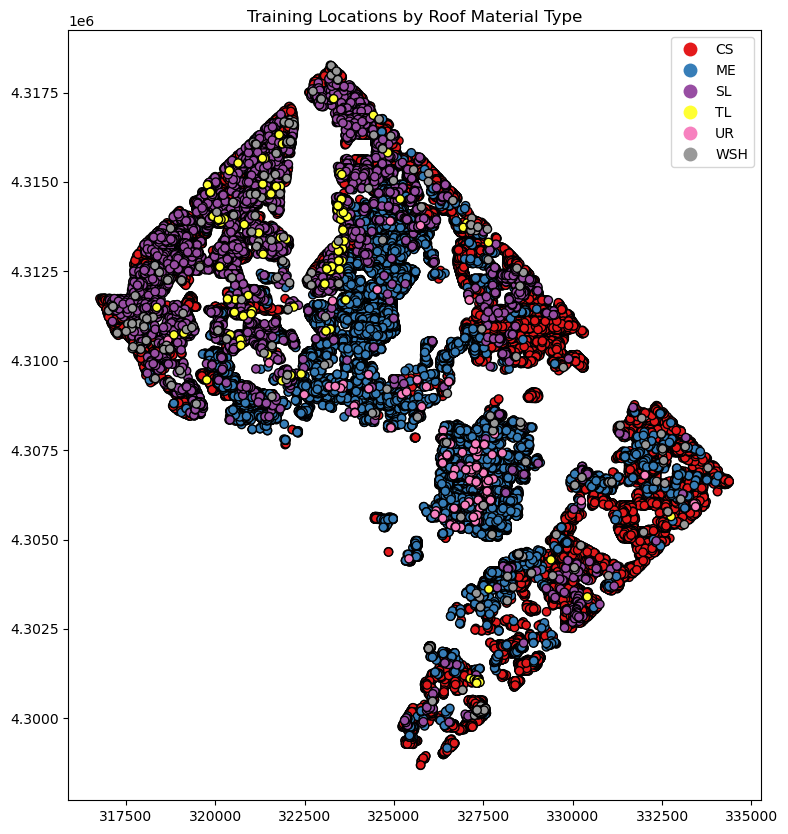

In [16]:
# Plot the training locations with colors based on roof type
fig, ax = plt.subplots(figsize=(10, 10))
training_gdf.plot(column='class_code', ax=ax, legend=True, cmap='Set1', edgecolor='black')
plt.title('Training Locations by Roof Material Type')
plt.show()

In [19]:
# Create a dictionary mapping class_code to code
class_mapping = dict(zip(training_gdf['class_code'], training_gdf['code']))
print(class_mapping)

{'CS': 0, 'ME': 1, 'SL': 2, 'UR': 3, 'TL': 4, 'WSH': 5}


In [20]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform balanced sampling (random undersampling)
training_gdf_ = balance_sampling(training_gdf, ratio=10, strategy='undersample')

training_gdf_.code.value_counts()

code
1    1980
0    1980
2    1980
5     475
3     252
4     198
Name: count, dtype: int64

In [21]:
# Split into train/test for each class
train_df, test_df, val_df = [], [], []

# Define split ratios
ts = 0.4  # Test size ratio
vs = 0.2  # Validation size ratio from remaining

# Perform initial stratified split to separate training data from test+validation data
train_df, temp_df = train_test_split(
    training_gdf_, # our filtered samples
    test_size=ts, 
    random_state=27, 
    stratify=training_gdf_['code']
)

# Perform stratified split on the temp_df to create validation and test sets
val_size = vs / (1 - ts)  # Adjust validation size to account for the initial split
val_df, test_df = train_test_split(
    temp_df, 
    test_size=val_size, 
    random_state=27, 
    stratify=temp_df['code']
)

# Print the class distribution in validation and test sets to verify stratification
print("Train class distribution:\n", train_df['code'].value_counts())
print("Validation class distribution:\n", val_df['code'].value_counts())
print("Test class distribution:\n", test_df['code'].value_counts())

Train class distribution:
 code
1    1188
2    1188
0    1188
5     285
3     151
4     119
Name: count, dtype: int64
Validation class distribution:
 code
0    528
2    528
1    528
5    126
3     67
4     53
Name: count, dtype: int64
Test class distribution:
 code
2    264
0    264
1    264
5     64
3     34
4     26
Name: count, dtype: int64


In [23]:
# Load image data 
stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_data_psscene15b_norm_r.tif')
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()
print(stack_da.shape)
print_raster(stack_da, open_file=False)
del stack_da

(8, 7555, 6046)
shape: (7555, 6046)
resolution: (3.0, -3.0)
bounds: (316269.0, 4295631.0, 334407.0, 4318296.0)
sum: 4.670212268829346
CRS: EPSG:32618
NoData: NoneArray: <xarray.DataArray (band: 8, y: 7555, x: 6046)> Size: 1GB
[365420240 values with dtype=float32]
Coordinates:
  * band         (band) int64 64B 1 2 3 4 5 6 7 8
  * x            (x) float64 48kB 3.163e+05 3.163e+05 ... 3.344e+05 3.344e+05
  * y            (y) float64 60kB 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        14.333673477173
    STATISTICS_MEAN:           -0.00047212314815042
    STATISTICS_MINIMUM:        -2.3788282871246
    STATISTICS_STDDEV:         1.002046040096
    STATISTICS_VALID_PERCENT:  42.96
    TIFFTAG_DATETIME:          2022:06:05 14:56:31
    TIFFTAG_IMAGEDESCRIPTION:  {"atmospheric_correction": {"aerosol_model": "...
    scale_factor:              1.0
    add_o

In [19]:
# Load training and validation datasets

imdir = stack_da_fp

bs = 128 # batch size
window_size = 64 # image dimensions

# Create the training samples
train_ds = RoofImageDataset_Planet(
    train_df[['geometry', 'code']], imdir, window_size
)
train_loader = DataLoader(
    train_ds, 
    batch_size=bs, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=make_good_batch,
    pin_memory=True # for GPU
)

# Create the validation samples
val_ds = RoofImageDataset_Planet(
    val_df[['geometry', 'code']], imdir, window_size
)
val_loader = DataLoader(
    val_ds, 
    batch_size=bs, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=make_good_batch,
    pin_memory=True # for GPU
)

# Create the test samples
test_ds = RoofImageDataset_Planet(
    test_df[['geometry', 'code']], imdir, window_size
)
test_loader = DataLoader(
    test_ds, 
    batch_size=bs, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=make_good_batch,
    pin_memory=True # for GPU
)

print("Training and validation data loaded!")

Training and validation data loaded!


In [40]:
# Set up the Resnet-18 model

# Grab the number of classes
n_classes = training_gdf_.class_code.unique().shape[0]
print(f'Building model for {n_classes} roof type classes.')

# Check on the number of CPU cores
import multiprocessing as mp
print(f'\nFYI, there are {mp.cpu_count()} cores on this machine.\n')

# Define the Resnet-18 model for 'n_classes'
# in_channels = number of bands for the input image
model = resnet18(n_classes, in_channels=8, pretrained=False)

# Check on device status, use GPU if available
device = "cpu" # default to using CPU
if torch.cuda.is_available():
    print("Using cuda:0 for model development ...")
    device = "cuda:0"
    if torch.cuda.device_count() == 1:
        print('\n leveraging a single GPU !\n')
        model = nn.DataParallel(model)
    elif torch.cuda.device_count() > 1:
        print(f'\n distributing work across {torch.cuda.device_count()} GPUs ! \n')
        model = nn.DistributedDataParallel(model)
    model.to(device) # transfer to GPU
else:
    print(f'\nUsing < {device} > for model development !\n')
    model = nn.DataParallel(model)

# Define the model hyper-parameters

# optimizer, learning rate scheduler, loss criterion
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

Building model for 6 roof type classes.

FYI, there are 6 cores on this machine.

Using cuda:0 for model development ...

 leveraging a single GPU !



In [42]:
imbalance = True

if imbalance is True:
    print("Generating class weights for loss function ...\n")
    # Number of samples in each class and total samples
    val_counts = list(train_df['code'].value_counts())
    total_samples = sum(val_counts)
    # Calculate class weights
    class_weights = [total_samples / count for count in val_counts]
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    # Print the calculated class weights for verification
    print(f"Class weights: {class_weights}")
    
    # Loss
    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = criterion

Generating class weights for loss function ...

Class weights: tensor([ 3.4672,  3.4672,  3.4672, 14.4526, 27.2781, 34.6134], device='cuda:0')


In [23]:
gc.collect()

45

In [24]:
# Model training !!!

In [25]:
# # Parameter tuning

# bss = [64, 128, 256]
# window_sizes = [24, 36, 64]

In [26]:
t0 = time.time()

print_freq=100
losses = []
epoch_loss = []
val_losses = []

start_epoch = 0
num_epochs=20
for epoch in range(start_epoch, num_epochs):
    #writer.add_scalar('train/learning_rate', lr_scheduler.get_lr()[0], epoch)
    print(f'learning rate: {lr_scheduler.get_lr()[0]}, epoch {epoch}')

    def check_for_nan_inf(tensor):
        return torch.isnan(tensor).any() or torch.isinf(tensor).any()
    
    model.train()
    for idx, batch in enumerate(train_loader):
        
        # extract samples
        image, target = batch['image'], batch['code']

        # Check for NaN values in the data
        if check_for_nan_inf(image):
            print(f'NaN or Inf found in image data at batch {idx}')
            del image, target, batch
            gc.collect()
            continue
        if check_for_nan_inf(target):
            print(f'NaN or Inf found in target data at batch {idx}')
            del image, target, batch
            gc.collect()
            continue
            
        image, target = image.to(device), target.to(device)
        
        output = model(image.float()) 
        loss = criterion(output, target.long())
            
        if check_for_nan_inf(loss):
            print(f'NaN or Inf found in loss at batch {idx}')
            del image, target, batch, output, loss
            gc.collect()
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % print_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(image), len(train_loader.dataset), 100. * idx / len(train_loader), loss.item()))
            #writer.add_scalar('train/loss', loss.item(), len(data_loader) * epoch + idx)
            print(f'train/loss {loss.item()} {len(train_loader) * epoch + idx}')
            losses.append((idx, loss.item()))

        # Clear variables to free up memory
        del image, target, batch, output, loss
        gc.collect()
            
    lr_scheduler.step() # add a step
    
    # average loss for the epoch
    epoch_loss.append(np.array(losses)[:,1].mean())
    
    # need validation dataset from CV fold
    model.eval() # Set model to evaluation
    
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
                
            # extract samples
            image, target = batch['image'], batch['code']

            image = image.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(image)
            val_loss += criterion(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

             # Clear variables to free up memory
            del image, target, batch, output, pred
            gc.collect()
            
        val_loss /= len(val_loader.dataset)/val_loader.batch_size

        val_losses.append(val_loss)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            100. * correct / len(val_loader.dataset)))
    
    # save_checkpoint(model, optimizer, epoch, epoch_loss[-1])

    t1 = (time.time() - t0) / 60
    print(f"Total elapsed time for epoch {epoch}: {t1:.2f} minutes.")
    print("\n~~~~~~~~~~\n")
    
    gc.collect()
    
    # torch.save(model.state_dict(), os.path.join(checkpoint_dir, "cls_epoch_{}.pth".format(epoch)))

t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

learning rate: 1e-05, epoch 0
Train Epoch: 0 [0/4119 (0%)]	Loss: 2.316471
train/loss 2.3164710998535156 0

Test set: Average loss: 1.9292, Accuracy: 499/1830 (27%)

Total elapsed time for epoch 0: 1.21 minutes.

~~~~~~~~~~

learning rate: 1e-05, epoch 1
Train Epoch: 1 [0/4119 (0%)]	Loss: 1.766705
train/loss 1.7667053937911987 33

Test set: Average loss: 1.7646, Accuracy: 499/1830 (27%)

Total elapsed time for epoch 1: 2.41 minutes.

~~~~~~~~~~

learning rate: 1e-05, epoch 2
Train Epoch: 2 [0/4119 (0%)]	Loss: 1.518938
train/loss 1.5189380645751953 66

Test set: Average loss: 1.7034, Accuracy: 241/1830 (13%)

Total elapsed time for epoch 2: 3.61 minutes.

~~~~~~~~~~

learning rate: 1e-05, epoch 3
Train Epoch: 3 [0/4119 (0%)]	Loss: 1.760122
train/loss 1.7601220607757568 99

Test set: Average loss: 1.6993, Accuracy: 271/1830 (15%)

Total elapsed time for epoch 3: 4.81 minutes.

~~~~~~~~~~

learning rate: 1e-05, epoch 4
Train Epoch: 4 [0/4119 (0%)]	Loss: 1.479758
train/loss 1.47975778579711

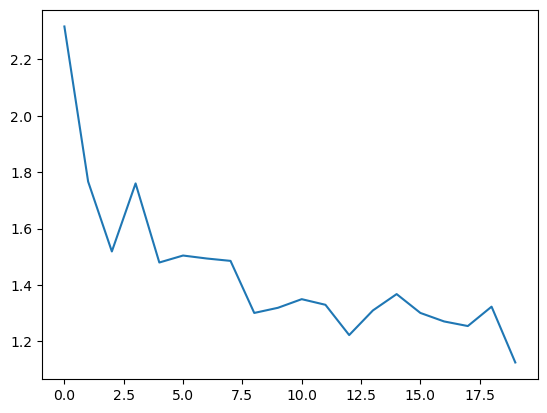

In [27]:
# Plot the model loss function
plt.plot(np.array(losses)[:,1])          

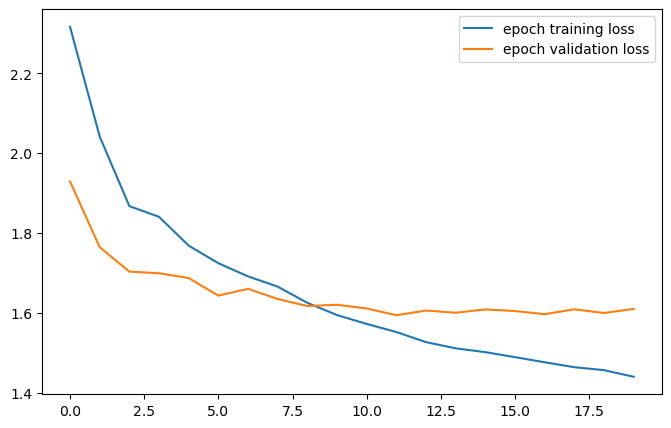

In [28]:
# Epoch training loss
plt.figure(figsize=(8, 5))

plt.plot(epoch_loss, label='epoch training loss')
plt.plot(val_losses, label='epoch validation loss')
plt.legend()
plt.show()

In [29]:
os.getcwd()

'/home/jovyan'

In [39]:
# directory
save_dir = 'results/'

In [ ]:
# Save the model

save_res = True

if save_res:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save the model
    step = len(losses)
    model_path = 'dc_planet_ms_ep{}_step{}_b{}.pt'.format(num_epochs, step, bs)
    model_path = os.path.join(save_dir, model_path)
    save = lambda ep: torch.save({
            'model': model.state_dict(),
            'epoch': epoch,
            'step': step,
        }, str(model_path))

    save(model_path)

In [ ]:
np.savetxt(os.path.join(save_dir, 'losses_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(losses))
np.savetxt(os.path.join(save_dir, 'epoch_loss_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(epoch_loss))
np.savetxt(os.path.join(save_dir, 'val_losses_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(val_losses))

In [30]:
import gc

def get_prediction(m, s):
    s = s.to(device)  # Ensure the sample is moved to the correct device
    res = m(s)
    return res

true_labels = []
pred_labels = []

model.eval()  # Set model to evaluation mode

for idx, sample in enumerate(test_ds):
    try:
        if sample['code'] != 255:
            # Append true labels
            true_labels.append(sample['code'].item())  # Convert tensor to Python scalar
                        
            # Get prediction and append
            pred = get_prediction(model, sample['image'][None, ...].float().to(device))  # Ensure tensor is float and on the correct device
            pred_labels.append(pred.argmax().item())  # Convert tensor to Python scalar
            
        else:
            print(f'sample {idx} of {len(test_ds)} had class label 255, skipping...')
        
        if idx % 100 == 0:
            time.sleep(0.3)
            gc.collect()
            print(f'Processed {idx} samples...')
        
    except Exception as e:
        print(f'Error at sample {idx}: {e}, continuing...')

Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...


In [31]:
# Ensure 'class_code' is of categorical dtype
test_df['code'] = test_df['code'].astype('category')

# Create the dictionary mapping
cat_dict = dict(enumerate(test_df['code'].cat.categories))
print(cat_dict)

# Filter the class codes present in the test set
class_codes_numbers = [k for k in cat_dict.keys() if cat_dict[k] in test_df['code'].unique().tolist()]

cor_labels = [cat_dict[c] for c in class_codes_numbers]
print(cor_labels)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
[0, 1, 2, 3, 4, 5]


(array([264.,   0., 264.,   0., 264.,   0.,  34.,   0.,  26.,  64.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

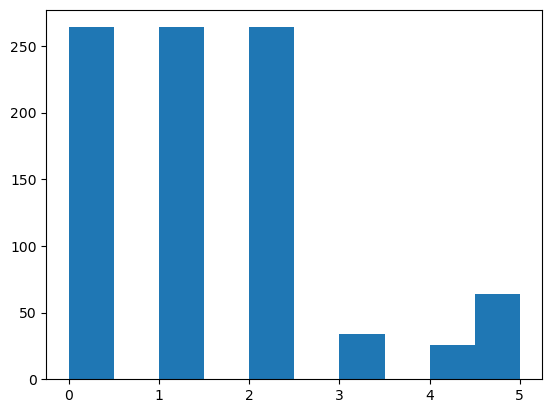

In [32]:
plt.hist(true_labels)

In [33]:
sum(p.numel() for p in model.parameters() if p.requires_grad) # number of trainable model parameters

23536006

In [34]:
# Generate the classification report
cr_df = pd.DataFrame(classification_report(true_labels, pred_labels, target_names=cor_labels, output_dict=True)).transpose()
print(cr_df)
# cr_df.to_csv(os.path.join(save_dir, f'dc_planet_ms_ep{num_epochs}_step{step}_b{bs}_classification_report.csv'))

              precision    recall  f1-score     support
0              0.500000  0.170455  0.254237  264.000000
1              0.638418  0.428030  0.512472  264.000000
2              0.432990  0.159091  0.232687  264.000000
3              0.153846  0.117647  0.133333   34.000000
4              0.000000  0.000000  0.000000   26.000000
5              0.078394  0.640625  0.139693   64.000000
accuracy       0.267467  0.267467  0.267467    0.267467
macro avg      0.300608  0.252641  0.212070  916.000000
weighted avg   0.464083  0.267467  0.302745  916.000000


In [35]:
for c in cor_labels:
    print(test_df.loc[test_df['code'] == c].shape[0])

264
264
264
34
26
64


In [36]:
cor_labels

[0, 1, 2, 3, 4, 5]

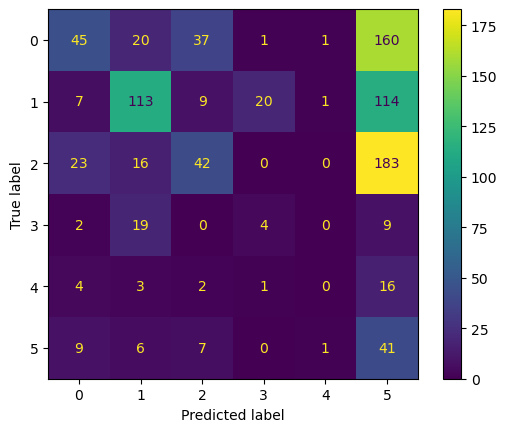

In [37]:
class_label_names = cor_labels 
class_labels = class_codes_numbers
cm = confusion_matrix(true_labels, pred_labels, labels=cor_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cor_labels)
disp.plot()